# PARTIE I : STATISTIQUES DESCRIPTIVES ET ETUDES DE CAS 
## A/PREMIERES TENDANCES AVEC LES STATS DESC


Le but de cette partie est d'évaluer les premières tendances que l'on pourrait remarquer. Notre objectif est de voir si on remarque facilement des spécifités géographiques dans la répartition des maladies

On importe tous les modules nécéssaires :

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

On importe nos base de travail issue de sources diverses mais généralement insee + data gouv (à modifier)

In [ ]:
#La base de données effectifs, notre base de travai principale qui nous renseigne sur les pathologies, issue de datagouv 
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

On réalise quelques histogrammes pour voir quels sont les tendances qui se dessinent :

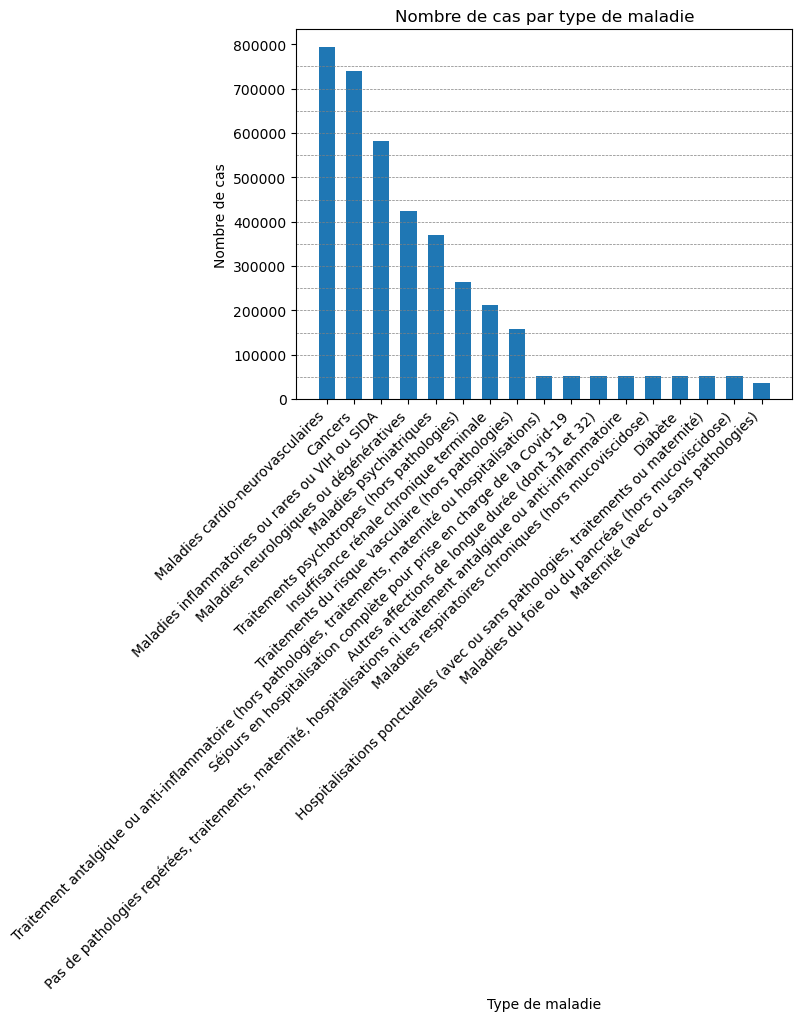

In [52]:
#Diagramme en barres sur le nombre de cas par type de maladie

# Compter le nombre de cas par type de maladie
counts = eff['patho_niv1'].value_counts()

# Créer le diagramme en barres
plt.bar(counts.index, counts.values,  width=0.6)
plt.xlabel('Type de maladie')
plt.ylabel('Nombre de cas')
plt.title('Nombre de cas par type de maladie')

# Ajouter des lignes horizontales en arrière-plan
for y in range(0, max(counts.values) + 1, 50000):  # Ajuster l'espacement des lignes selon vos besoins
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.5)

# Rotation des étiquettes en diagonale
plt.xticks(rotation=45, ha='right')

plt.show()

On remarque que parmi les pathologies de niveau 1 (le niveau le moins précis), les cancers sont avec les maladies cardio vasculaires les premières maladies dont sont atteints les individus de la base. Il est donc intéressant à cet égard de regarder ce type de maladie pour avoir des résultats significatifs par la suite.

Nous avons par ailleurs à disposition des variables descriptives liées à la pollution. En effet,à l'aide d'une table (PRECISER LA TABLE ET SO ORIGINE) nous sommes 
en capacité d'estimer la quantité mais égalment la source de pollution de chaque département comme un varibale supplémentaire servant à caractériser
l'environnement (et les maladies qui peuvent en découler) des départements francais. Ces informations seront notamment utilisées plus en amont dans le code mais 
nous l'ajoutons d'ores et déja.


In [ ]:
data_pollution = pd.read_csv("https://koumoul.com/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert", encoding = 'utf-8')

#Création de la variable département à partir du code commune de l'INSEE
data_pollution['DEP'] = data_pollution['INSEE commune'].str[:2]

#Somme des niveaux de pollution par département
pollution_group_dep = data_pollution.drop(['Commune','INSEE commune'], axis = 1).groupby('DEP', as_index=False).sum()
pollution_group_dep

# Importation des bases en local pour faire tourner le code main
data_pollution.to_csv('base_pollution.csv', sep=',', index=False, encoding='utf-8')
pollution_group_dep.to_csv('pollution_group_dep.csv', sep=',', index=False, encoding='utf-8')

In [ ]:
## B/ETUDES DE CAS 

### 1/PREMIERE ETUDE DE CAS : LES CANCERS DE LA PROSTATE SONT-ILS PLUS NOMBREUX EN BRETAGNE ? 

Dans cette premiere étude de cas nous chercherons à comprendre si en étudiant une variable saillante, qui caractérise bien un département mais qui est 
également en lien direct avec l'apparition d'une certaine maladie, nous sommes en mesure ou non d'inférer les fait que la proportion maladie en question va être 
particulièrement élevé dans le département en question .

Nous avons déccider de nous pencher sur un cas qui a déjà marqué l'actualié : la polluton agricole en Bretagne. D'apres la fondation pour la nature et l'homme
la pollution liée à l'agriculture favoriserait un cetain nombre de maladies comme les cancers de la prostate. Nous allons donc essayer de voir si dans le département 
29, le Finistère, le taux de cancer de la prostate parmi la population est plus sélevé que la moyenne. 

Vérifions d'abord avec nos données qu'une forte pollution liée à l'agriculture est bien une caratéristque du Finistère :

In [53]:
#Choisir le numéro du département dont on veut observer les sources de pollution
x = input("Entrer un numéro de département (mettre un 0 devant si c'est un chiffre) : ")

Entrer un numéro de département (mettre un 0 devant si c'est un chiffre) :  29


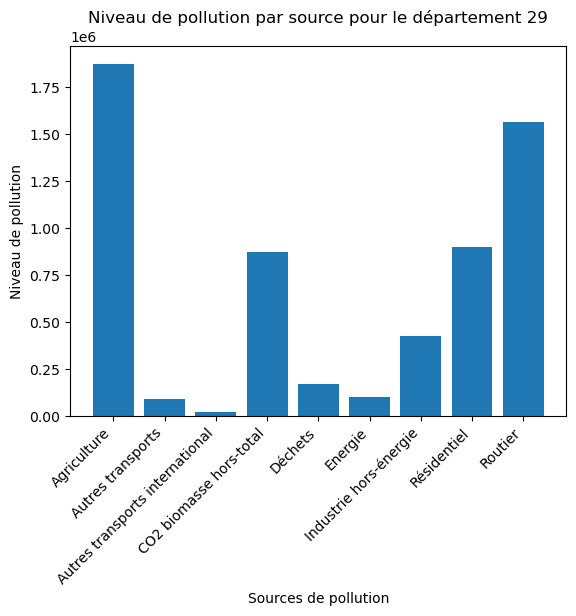

In [54]:
# Sélectionnez les données pour le département x
pollution_dep_91 = pollution_group_dep[pollution_group_dep['DEP'] == x]

# Sélectionnez les colonnes correspondant aux sources de pollution
sources_pollution = pollution_dep_91.columns[1:10]

# Créez un diagramme en barres
plt.bar(sources_pollution, pollution_dep_91.iloc[0, 1:10])
plt.xlabel('Sources de pollution')
plt.ylabel('Niveau de pollution')
plt.title('Niveau de pollution par source pour le département {}'.format(x))
plt.xticks(rotation=45, ha='right')

plt.show()


On constate donc qu'il y a bien une forte pollution liée à l'agriculture dans le 29, on va maintenant chercher à comparer la prévalence de cancer de la prostate dans la Finistère et dans les autres départements.

Pour se faire, nous allons recourir à une copie de notre base de données intiale que nous renommeront base_grande. Cette va être retravaillée afin de convenir à notre démarche. On va par exemple changer les classes d'âges et les transformer en un age unique. On va aussi utiliser dummies afin de créer des variables catégorielles sur chacun de nos pathologie de niveau 2 pour pouvoir isoler plus facilement les individus atteints d'un cancer de la prostate. 

In [ ]:
#Par rapport aux autres histogramme ici on va prendre pathoniv2 pour les dummies 
base_grande = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')
base_grande.shape
base_grande = base_grande.dropna()
base_grande = pd.get_dummies(base_grande, prefix = 'indicatrice_', columns=['patho_niv2'], dtype='int')


liste_var = base_grande.columns[17:]
liste_bis = []
for i in liste_var : 
    liste_bis.append(i)
indicatrice_patho_niv1 = liste_bis

liste_auxil = base_grande['cla_age_5'].unique()
inter_excl = ('95et+', 'tsage', np.nan)

inter_def = []
for i in liste_auxil :
    if i in inter_excl : 
        inter_def = inter_def
    else : 
        inter_def.append(i)
classe_age = []
for i in base_grande['cla_age_5'] : 
    if i in inter_def :
        temp = i.split('-')
        temp[0] = int(temp[0])
        temp[1] = int(temp[1])
        age = (temp[1] + temp[0])/2
    elif i == 'tsage' : 
        age = np.nan
    elif i == '95et+' : 
        age = 100
    else : 
        age = np.nan
    classe_age.append(age)
base_grande.loc[:,'classe_age'] = classe_age

In [ ]:
On créer ensuite une nouvelle base de données de laquelle on ne garde que les colonnes qui nous sont utiles, à savoir le département et la variable catégorielle qui porte 
sur la pathologie étudiée

In [ ]:
#On supprime les espaces dans le noms des colonnes 
base_grande.columns = base_grande.columns.str.replace(' ', '_')

model_prostate = base_grande[['dept', 'classe_age','indicatrice__Cancer_de_la_prostate','sexe','region']]

In [ ]:
#On prend la liste des départements observés afin de généralisé notre démarche
valeurs_uniques = model_prostate['dept'].unique()
#print(valeurs_uniques)

resultats = model_prostate.groupby('dept')['indicatrice__Cancer_de_la_prostate'].agg(['count', 'sum'])

# Renommer les colonnes
resultats.columns = ['pop_i', 'pop_i2']

# Remplacer les valeurs manquantes par 0
resultats['pop_i2'].fillna(0, inplace=True)

# Initialiser la variable pour la moyenne
moyenne_totale = 0

# Calculer le pourcentage de cancer de la prostate par département et afficher les résultats
for index, row in resultats.iterrows():
    if row['pop_i'] != 0:
        pourcentage_cancer = (row['pop_i2'] / row['pop_i']) * 100
        moyenne_totale += pourcentage_cancer
        print(f"Il y a {pourcentage_cancer:.2f}% de cancer de la prostate dans le département {index}.")
    else:
        print(f"Aucun individu dans le département {index} dans votre DataFrame.")

# Calculer la moyenne totale
if len(resultats) > 0:
    moyenne_totale /= len(resultats)
    print(f"\nLa moyenne totale des pourcentages de cancer de la prostate est {moyenne_totale:.2f}%.")
else:
    print("\nAucun résultat à moyenner, car tous les départements ont une population de 0.")



In [ ]:
###CONCLUSION DE CETTE ETUDE DE CAS 

On constate alors qu'un 1,73% de la population du Finistère est atteinte d'un cancer de l' u n   ce, ce qui est moins que la moyenne nationale. Cela nous renseine sur la 
difficulté qu'il peut en réalité y avoir à essayer d'inférer le nombre de maladie dans un département en fonction de certaine de ses caractéristiques prises isolément. C'est ausi ce que 
semblait affirmer l'article de la fondation pour la nature et l'homme (https://www.fnh.org/pesticides-hauts-risques-pour-la-sante-des-agriculteurs-et-les-riverains/) quand elle affirme que
"cette cancérogénicité est validée formellement mais pas statistiquement". 

On tient néanmoins à souligner que cela ne signifie pas qu'étuder le département ne puisse pas donner de résultats significatifs. Le cas des outre mer est assez frappant. En effet, en France métropolitaine 
seuls le Gers (32), la Creuse (23), l'Ariège (09) le Lot (46) et la Lozère (48) dépassent les 2% de la population atteinte par un cancer de la prostate. Alors que 3 départements d'outre mer sur cinq
la Goudeloupe (971), la Guyane (973) et la Mayotte (976) se place au dessus de 2%. Autrement dit, ce n'est pas que des variables inhérentes au département ne peuvent
pas expliquer la propention de ses habitants à êre atteints ou non de certaines maladies, mais la difficulté de systématiser cette analyse avec des variables simples. 




### 2/ SECONDE ÉTUDES DE CAS ETUDES DE CAS : PEUT ON ESTIMER LA PROPORTION D'HOSPITALISATION EN FONCTION DU REVENU DES HABITANTS D'UN DEPARTEMENT DONNÉ ? 

Notre objectif pour cette seconde étude de cas c'est de déterminer si le département est une unité spatiale pertinente quant à sa capcité à refléter les pratiques
médicales de la population qui y réside. La manière dont nous allons procéder est de nous référer aux pratiques médicales des individus en fonction de leur niveau de revenu.
TEL ARTICLE DE SOCIO A INSERER affirme par exemple que les indivdus ayant les revenus les plus élevés se soigneraient plus souvent que ceux ayant les revenus le moins élevés. 
On pourrait alors envisager qu'un département riche compterait plus d'hospitalisation qu'un département plus pauvre. 
On va alors pour avoir une bonne idée du revenus des individus au sein d'un département utiliser le classemnt PIB par habitant des départements et
ainsi en comparer plusieurs très élognés dans le classement. 



In [ ]:
pollution_group_dep = pd.read_csv("pollution_group_dep.csv", sep = ",", encoding = 'utf-8', engine = 'python')

In [ ]:
url = 'https://www.insee.fr/fr/statistiques/fichier/1893198/estim-pop-dep-sexe-gca-1975-2023.xls'

noms_colonnes=['numero_dep','dep','total_habitants']
pop_test = pd.read_excel(url, sheet_name='2023',skiprows=3,header=1, usecols = [0,1,7], skipfooter=4, names=noms_colonnes)


#pop_test2 = pop_test.set_index(['Num_dep ', 'Nom_dep'])
#pop_test2

#pop_test3 = pop_test.drop(df.index[:3])
#print(pop_test3)

pop_test.to_csv('base_pop_dep.csv')

In [ ]:
pop = pd.read_csv('base_pop_dep.csv', sep = ",", encoding = 'utf-8', engine = 'python')

In [ ]:
pop = pop.drop(['Unnamed: 0'], axis=1)

In [ ]:
# Fusion des tables effectifs, pop et pollution_group_dep

merged_df = pd.merge(eff, pollution_group_dep, left_on=['dept'], right_on=['DEP'], 
                    how='inner')
pop_eff_pol = pd.merge(merged_df, pop, left_on=['DEP'], right_on=['numero_dep'], 
                    how='inner')

# Supprimer les colonnes redondantes
pop_eff_pol = pop_eff_pol.drop(['numero_dep', 'dept'], axis=1)

#Pour ne pas confondre les variables DEP (int) et dep (str)
pop_eff_pol = pop_eff_pol.rename(columns={'dep': 'nom_dep'})

In [ ]:
#Les données datent de 2015 à 2020, 
#on prend le classement par PIB par habitant par département et on garde 
#le dep avec le PIB par habitant le plus élevé (Paris (75), pib/habitant de 127 132€)
#celui où il est le plus faible (la Creuse (23), pib/habitant de 23 192€),
#et celui qui est le plus près de la moyenne nationale (Bas-Rhin (67)).
#Le PIB moyen par habitant en 2021 est de 37 431€ par an.
# source : wikipedia
#---> En faire un markdown ? 

In [ ]:
pop_eff_pol['nom_dep'].unique()

In [ ]:
# Filtrer les données pour le département 75 (Paris) et la variable patho_niv1
paris_data = pop_eff_pol[pop_eff_pol['nom_dep'] == 'Paris']
hospitalized_data = paris_data[paris_data['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)']

# Calculer la proportion de personnes hospitalisées
proportion_hospitalized = len(hospitalized_data) / paris_data['total_habitants'].sum()

# Créer un histogramme
labels = ['Hospitalisés', 'Non hospitalisés']
sizes = [proportion_hospitalized, 1 - proportion_hospitalized]

fig, ax = plt.subplots()
ax.bar(labels, sizes, color=['blue', 'gray'])
ax.set_ylabel('Proportion')
ax.set_title('Proportion de personnes hospitalisées dans le département 75 (Paris)')

plt.show()

In [ ]:
pop_eff_pol['niveau_prioritaire'].replace('1,2,3', np.nan, inplace=True)

In [ ]:
# Filtrer les données pour le département 75 (Paris)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Paris')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire à Paris')

# Fonction pour ajouter les pourcentages au-dessus des barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height, f'{height:.1%}',
                ha='center', va='bottom')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

In [ ]:
# Filtrer les données pour le département 23 (Creuse)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Creuse')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

In [ ]:
# Filtrer les données pour le département 67 (Bas-Rhin)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Bas-Rhin')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['mediumseagreen', 'navajowhite', 'lightcoral', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

In [ ]:
# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = pop_eff_pol.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

## CONCLUSION DE CETTE ETUDES DE CAS :

Cellule markdown de conclusion  + 
La conclusion est a varier selon ce qu'on laisse dans cette partie la.
L'idée fondamentale étant :
" On observe des résultats opposés à ceux auxquels on pouvaient intuitivement s'attendre. En effet, les hospitalisations dans les départements riches ne semble pas excéder celles dans des 
départements plus modestes. Il s'agit peut-être de l'effet agrégeant du département qui en mêlant plusieurs variales et individus asne t   p l u  , diminue le poids d'une variable
comme la richesse des habitants. On peut donc en conclure qu'il semble a minima difficile d'estimer que certaines varibales propres a certain département
puissent expliquer le comportement médical moyen des individus qui y résident"

transition vers la partie 2 qui pourrait être qq chose comme

" La difficulté est alors de se demander quelles sont les variables parmi celles dont on a accès, dont le poids va pouvoir bien expliquer le niveau de maladie
au sein d'un département et donc de juger si le département est bien une unité qui nous dit quelque chose de la manière sont sont représentées spatialement les maladies" 
ca reste à modifier selon 

# LIMITE DE CETTE APPROCHE 
La limite de cette approche descriptive réside evidemment dans l'impossibilité de multiplier à l'infini toutes les histogrammes possibles et de tester tous les cas 
de figure afin de vérifier si nos résultats sont dus au hasard ou s'il semble bien compliqué d'expliquer l'état de santé de la population par ces quelques variab   q u e l q 
Nous avons en travaillant sur ce projet exploré d'autres pistes et réalisés d'autres graphiques, mais les conclusions qui seront tirées en partie II nous incite à ne pas chercher 
d'avantage à creuser cette piste.

